In [1]:
import pathlib
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import torchvision.models as models
from torchvision.transforms import transforms

# CPU only for Kaggle safe run
device = "cpu"
print("Using device:", device)


Using device: cpu


In [2]:
BASE_DIR = pathlib.Path("/kaggle/input/recodai-luc-scientific-image-forgery-detection")
TRAIN_IMG_DIR = BASE_DIR / "train_images"

AUTHENTIC_DIR = TRAIN_IMG_DIR / "authentic"
FORGED_DIR = TRAIN_IMG_DIR / "forged"

print("Number of authentic images:", len(list(AUTHENTIC_DIR.iterdir())))
print("Number of forged images:", len(list(FORGED_DIR.iterdir())))


Number of authentic images: 2377
Number of forged images: 2751


In [3]:
IMG_PATHS = []

for p in AUTHENTIC_DIR.iterdir():
    IMG_PATHS.append({"type": "authentic", "path": p})
for p in FORGED_DIR.iterdir():
    IMG_PATHS.append({"type": "forged", "path": p})

df = pd.DataFrame(IMG_PATHS).sample(frac=1).reset_index(drop=True)
df["label"] = df["type"].map({"authentic": 0, "forged": 1})

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_df.shape, test_df.shape


((4102, 3), (1026, 3))

In [4]:
class LUCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, row.label

    def __len__(self):
        return len(self.df)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

train_ds = LUCDataset(train_df, transform)
test_ds = LUCDataset(test_df, transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)


In [5]:
class BASEModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Offline ResNet18
        self.backbone = models.resnet18(weights=None)

        # Freeze backbone
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Small classifier for fast CPU
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

model = BASEModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:
EPOCHS = 5
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    batch_losses = []
    for img, labels in train_dl:
        img, labels = img.to(device), labels.to(device)

        optimizer.zero_grad()
        pred = model(img)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))

    # Test loss
    model.eval()
    test_batch_losses = []
    with torch.no_grad():
        for img, labels in test_dl:
            img, labels = img.to(device), labels.to(device)
            out = model(img)
            loss = loss_fn(out, labels)
            test_batch_losses.append(loss.item())
    test_losses.append(np.mean(test_batch_losses))

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_losses[-1]:.4f} - Test Loss: {test_losses[-1]:.4f}")


Epoch 1/5 - Train Loss: 0.6998 - Test Loss: 0.6888
Epoch 2/5 - Train Loss: 0.6926 - Test Loss: 0.6889
Epoch 3/5 - Train Loss: 0.6911 - Test Loss: 0.6885
Epoch 4/5 - Train Loss: 0.6922 - Test Loss: 0.6895
Epoch 5/5 - Train Loss: 0.6909 - Test Loss: 0.6888


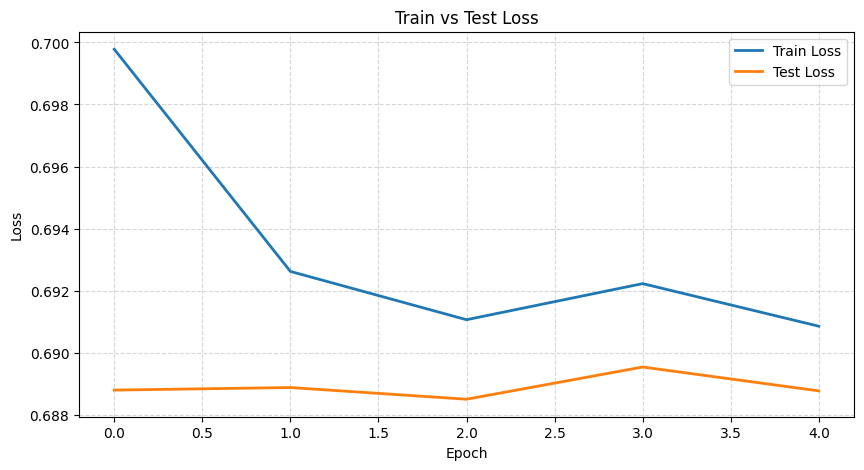

In [7]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(test_losses, label="Test Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


Test Accuracy: 0.5360623781676414


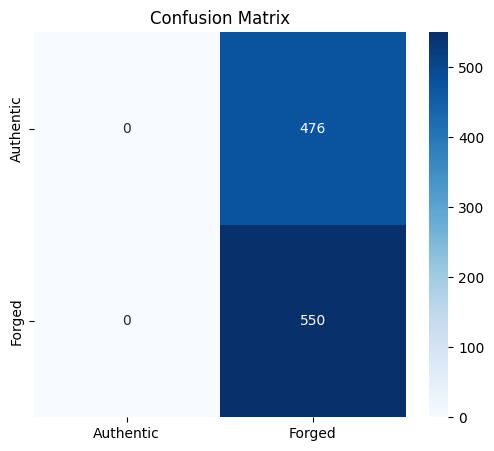

submission.csv saved at: /kaggle/working/submission.csv


In [8]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for img, labels in test_dl:
        img = img.to(device)
        out = model(img)
        preds = torch.argmax(out, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", acc)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Authentic", "Forged"],
            yticklabels=["Authentic", "Forged"])
plt.title("Confusion Matrix")
plt.show()

# Submission File
submission = pd.DataFrame({
    "Id": test_df.index,
    "Predicted": all_preds
})
submission_path = "/kaggle/working/submission.csv"
submission.to_csv(submission_path, index=False)
print("submission.csv saved at:", submission_path)
